## Training attention based model

In [1]:
%matplotlib inline

import sys
sys.path.append("../../")

from train_model import train

from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot, PredictionError

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 4)
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'
rcParams['axes.facecolor'] = '#ffffff'
rcParams['lines.linewidth'] = 2.0

In [2]:
import os
file_path = r"D:\Final_file\ASI-main\output\models\IT\asi_IT_weights.hdf5"
from tensorflow.keras import backend as K
K.clear_session()

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Removed the file: {file_path}")
else:
    print(f"The file {file_path} does not exist")

Removed the file: D:\Final_file\ASI-main\output\models\IT\asi_IT_weights.hdf5


In [3]:
##BEST IT

hyperparameter={
"num_nearest":40,
"sigma":2,
"geointerpolation": 'asi_multi',
'type_compat_funct_eucli':'identity',
'Num_heads':8,
"learning_rate":0.001,
"batch_size":250,
"num_neuron":60,
"num_layers":5,
"size_embedded":50,
"num_nearest_geo":30,
"num_nearest_eucli":25,
"id_dataset":'IT',
"epochs":300,
"optimier":'adam',
"validation_split":0.1,
"label":'asi_IT',
"early_stopping": False,
'scale_log':False,
"graph_label":'matrix',
}

In [4]:
spatial = train(**hyperparameter)

In [5]:
dataset,\
result,\
fit,\
embedded_train,\
embedded_test,\
predict_regression_train,\
predict_regression_test = spatial()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/300
90/90 [==============================] - 18s 68ms/step - loss: 258842.4062 - root_mean_squared_error: 300160.6562 - val_loss: 163632.9844 - val_root_mean_squared_error: 212051.8125

Epoch 00001: val_loss improved from inf to 163632.98438, saving model to d:\Final_file\ASI-main/output/models/IT\asi_IT_weights.hdf5
Epoch 2/300
90/90 [==============================] - 4s 44ms/step - loss: 81662.5547 - root_mean_squared_error: 110743.2734 - val_loss: 56361.2617 - val_root_mean_squared_error: 74362.9141

Epoch 00002: val_loss improved from 163632.98438 to 56361.26172, saving model to d:\Final_file\ASI-main/output/models/IT\asi_IT_weights.hdf5
Epoch 3/300
90/90 [==============================] - 6s 66ms/step - loss: 49579.0742 - root_mean_squared_error: 67181.5469 - val_loss: 47245.8242 - val_root_mean_squared_er

KeyboardInterrupt: 

In [7]:
print('################# Test ##########################')
print('MALE test:.... {}'.format(result[0]))
print('RMSE test:.... {}'.format(result[1]))
print('MAPE test:.... {}'.format(result[2]))
print('################# Train ##########################')
print('MALE train:.... {}'.format(result[3]))
print('RMSE train:.... {}'.format(result[4]))
print('MAPE train:.... {}'.format(result[5]))

################# Test ##########################
MALE test:.... 31108.490243218384
RMSE test:.... 45881.47013910173
MAPE test:.... 9.48586222091657
################# Train ##########################
MALE train:.... 29212.475114081008
RMSE train:.... 44309.13087955271
MAPE train:.... 8.425810999142366


In [7]:
print('################# Test ##########################')
print('MALE test:.... {}'.format(result[0]))
print('RMSE test:.... {}'.format(result[1]))
print('MAPE test:.... {}'.format(result[2]))
print('################# Train ##########################')
print('MALE train:.... {}'.format(result[3]))
print('RMSE train:.... {}'.format(result[4]))
print('MAPE train:.... {}'.format(result[5]))

################# Test ##########################
MALE test:.... 31445.386577887493
RMSE test:.... 46176.12268482518
MAPE test:.... 9.661953399936273
################# Train ##########################
MALE train:.... 28956.64211483623
RMSE train:.... 43849.90255262254
MAPE train:.... 8.307500840973361


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


## Base models benchmarking 

In [9]:
X_train ,X_test, y_train , y_test = dataset.X_train,dataset.X_test,dataset.y_train,dataset.y_test

In [10]:

# Define the mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize lists to store test set evaluation metrics for each model
test_mae_list = {}
test_mse_list = {}
test_rmse_list = {}
test_r2_list = {}
test_mape_list = {}

# Define the models and their respective parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [5, 10, 15, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [5, 9, 12, 15]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 150], 'max_depth': [8, 12, 16]}
    },
    'SVM': {
        'model': SVR(),
        'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {'n_estimators': [1000, 2000], 'learning_rate': [0.01, 0.05, 0.1]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0, n_estimators=2000),
        'params': {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.05]}
    },
    'XGBoost': {
        'model': XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42),
        'params': {'max_depth': [5, 7, 9], 'learning_rate': [0.01, 0.05, 0.1]}
    }
}

# Define the K-fold cross-validator
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# For each model
for name, model_info in models.items():
    test_mae_list[name] = []
    test_mse_list[name] = []
    test_rmse_list[name] = []
    test_r2_list[name] = []
    test_mape_list[name] = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Grid Search for hyperparameter tuning
        grid = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
        grid_result = grid.fit(X_train_fold, y_train_fold)
        best_model = grid_result.best_estimator_

        # Make predictions on the test set
        y_pred_test = best_model.predict(X_test)

        # Evaluate the model on the test set
        test_mae = mean_absolute_error((y_test), (y_pred_test))
        test_mse = mean_squared_error((y_test), (y_pred_test))
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score((y_test), (y_pred_test))
        test_mape = mean_absolute_percentage_error((y_test), (y_pred_test))

        # Store the test set metrics in the lists
        test_mae_list[name].append(test_mae)
        test_mse_list[name].append(test_mse)
        test_rmse_list[name].append(test_rmse)
        test_r2_list[name].append(test_r2)
        test_mape_list[name].append(test_mape)

    # Calculate the average and best metrics for the test set
    avg_test_mae = np.mean(test_mae_list[name])
    avg_test_mse = np.mean(test_mse_list[name])
    avg_test_rmse = np.mean(test_rmse_list[name])
    avg_test_r2 = np.mean(test_r2_list[name])
    avg_test_mape = np.mean(test_mape_list[name])

    best_test_mae = np.min(test_mae_list[name])
    best_test_mse = np.min(test_mse_list[name])
    best_test_rmse = np.min(test_rmse_list[name])
    best_test_r2 = np.max(test_r2_list[name])
    best_test_mape = np.min(test_mape_list[name])

    print(f"Test Set Evaluation for {name}")
    print(f"Average Test MAE: {avg_test_mae}, Best Test MAE: {best_test_mae}")
    print(f"Average Test MSE: {avg_test_mse}, Best Test MSE: {best_test_mse}")
    print(f"Average Test RMSE: {avg_test_rmse}, Best Test RMSE: {best_test_rmse}")
    print(f"Average Test R2: {avg_test_r2}, Best Test R2: {best_test_r2}")
    print(f"Average Test MAPE: {avg_test_mape}, Best Test MAPE: {best_test_mape}")
    print("\n")


Test Set Evaluation for Linear Regression
Average Test MAE: 58248.13316731188, Best Test MAE: 58220.72700688014
Average Test MSE: 5820154869.722492, Best Test MSE: 5816667249.895552
Average Test RMSE: 76289.93798425773, Best Test RMSE: 76267.07841457907
Average Test R2: 0.7419230161526501, Best Test R2: 0.7420776639972333
Average Test MAPE: 29.570621461469575, Best Test MAPE: 29.525426299008096


Test Set Evaluation for KNN
Average Test MAE: 57216.243911707636, Best Test MAE: 57055.0120633894
Average Test MSE: 6314314623.89526, Best Test MSE: 6261902649.848174
Average Test RMSE: 79462.4622736218, Best Test RMSE: 79132.1846649527
Average Test R2: 0.7200110117901724, Best Test R2: 0.7223350606311961
Average Test MAPE: 26.173408840770286, Best Test MAPE: 25.94855035801249


Test Set Evaluation for Decision Tree
Average Test MAE: 54664.7606243349, Best Test MAE: 54065.62741178708
Average Test MSE: 5769654995.360704, Best Test MSE: 5540726628.855011
Average Test RMSE: 75935.461358632, Best 

## Testing the embeddings

In [11]:


X_train ,X_test, y_train , y_test = embedded_train,embedded_test,dataset.y_train,dataset.y_test


# Initialize lists to store test set evaluation metrics for each model
test_mae_list = {}
test_mse_list = {}
test_rmse_list = {}
test_r2_list = {}
test_mape_list = {}

# Define the models and their respective parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [5, 10, 15, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [5, 9, 12, 15]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 150], 'max_depth': [8, 12, 16]}
    },
    'SVM': {
        'model': SVR(),
        'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {'n_estimators': [1000], 'learning_rate': [0.05, 0.1]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0, n_estimators=2000),
        'params': {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.05]}
    },
    'XGBoost': {
        'model': XGBRegressor(n_estimators=2000, learning_rate=0.05, random_state=42),
        'params': {'max_depth': [5, 7, 9], 'learning_rate': [0.01, 0.05, 0.1]}
    }
}

# Define the K-fold cross-validator
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# For each model
for name, model_info in models.items():
    test_mae_list[name] = []
    test_mse_list[name] = []
    test_rmse_list[name] = []
    test_r2_list[name] = []
    test_mape_list[name] = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Grid Search for hyperparameter tuning
        grid = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
        grid_result = grid.fit(X_train_fold, y_train_fold)
        best_model = grid_result.best_estimator_

        # Make predictions on the test set
        y_pred_test = best_model.predict(X_test)

        # Evaluate the model on the test set
        test_mae = mean_absolute_error((y_test), (y_pred_test))
        test_mse = mean_squared_error((y_test), (y_pred_test))
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score((y_test), (y_pred_test))
        test_mape = mean_absolute_percentage_error((y_test), (y_pred_test))

        # Store the test set metrics in the lists
        test_mae_list[name].append(test_mae)
        test_mse_list[name].append(test_mse)
        test_rmse_list[name].append(test_rmse)
        test_r2_list[name].append(test_r2)
        test_mape_list[name].append(test_mape)

    # Calculate the average and best metrics for the test set
    avg_test_mae = np.mean(test_mae_list[name])
    avg_test_mse = np.mean(test_mse_list[name])
    avg_test_rmse = np.mean(test_rmse_list[name])
    avg_test_r2 = np.mean(test_r2_list[name])
    avg_test_mape = np.mean(test_mape_list[name])

    best_test_mae = np.min(test_mae_list[name])
    best_test_mse = np.min(test_mse_list[name])
    best_test_rmse = np.min(test_rmse_list[name])
    best_test_r2 = np.max(test_r2_list[name])
    best_test_mape = np.min(test_mape_list[name])

    print(f"Test Set Evaluation for {name}")
    print(f"Average Test MAE: {avg_test_mae}, Best Test MAE: {best_test_mae}")
    print(f"Average Test MSE: {avg_test_mse}, Best Test MSE: {best_test_mse}")
    print(f"Average Test RMSE: {avg_test_rmse}, Best Test RMSE: {best_test_rmse}")
    print(f"Average Test R2: {avg_test_r2}, Best Test R2: {best_test_r2}")
    print(f"Average Test MAPE: {avg_test_mape}, Best Test MAPE: {best_test_mape}")
    print("\n")


Test Set Evaluation for Linear Regression
Average Test MAE: 31183.864596008858, Best Test MAE: 31163.89224712969
Average Test MSE: 2110419608.897288, Best Test MSE: 2106919119.0934873
Average Test RMSE: 45939.2989098897, Best Test RMSE: 45901.188645758266
Average Test R2: 0.906419890963746, Best Test R2: 0.906575109488128
Average Test MAPE: 13.958334537685923, Best Test MAPE: 13.938464716758306


Test Set Evaluation for KNN
Average Test MAE: 32095.10818078913, Best Test MAE: 32009.23657018111
Average Test MSE: 2184419818.741751, Best Test MSE: 2176094351.9597545
Average Test RMSE: 46737.754655025135, Best Test RMSE: 46648.626474524994
Average Test R2: 0.9031385777705042, Best Test R2: 0.9035077451559628
Average Test MAPE: 14.335584817434475, Best Test MAPE: 14.314393308807066


Test Set Evaluation for Decision Tree
Average Test MAE: 31664.842515937016, Best Test MAE: 31619.090044911387
Average Test MSE: 2132132672.5307765, Best Test MSE: 2126799310.185113
Average Test RMSE: 46175.00743

## Applying pca

In [12]:
from sklearn.decomposition import PCA

# Apply PCA to embedded_train and embedded_test to reduce embeddings to 12 dimensions
pca = PCA(n_components=6)
embedded_train_pca = pca.fit_transform(embedded_train)
embedded_test_pca = pca.transform(embedded_test)

# Concatenate dataset.X_train with embedded_train_pca and dataset.X_test with embedded_test_pca
X_train_concat = np.concatenate((dataset.X_train, embedded_train_pca), axis=1)
X_test_concat = np.concatenate((dataset.X_test, embedded_test_pca), axis=1)

In [13]:
X_train_concat = np.concatenate((dataset.X_train, embedded_train), axis=1)
X_test_concat = np.concatenate((dataset.X_test, embedded_test), axis=1)

In [14]:
X_train ,X_test, y_train , y_test = X_train_concat,X_test_concat,dataset.y_train,dataset.y_test

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8732
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 49
[LightGBM] [Info] Start training from score 268770.931835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8732
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 49
[LightGBM] [Info] Start training from score 268770.931835


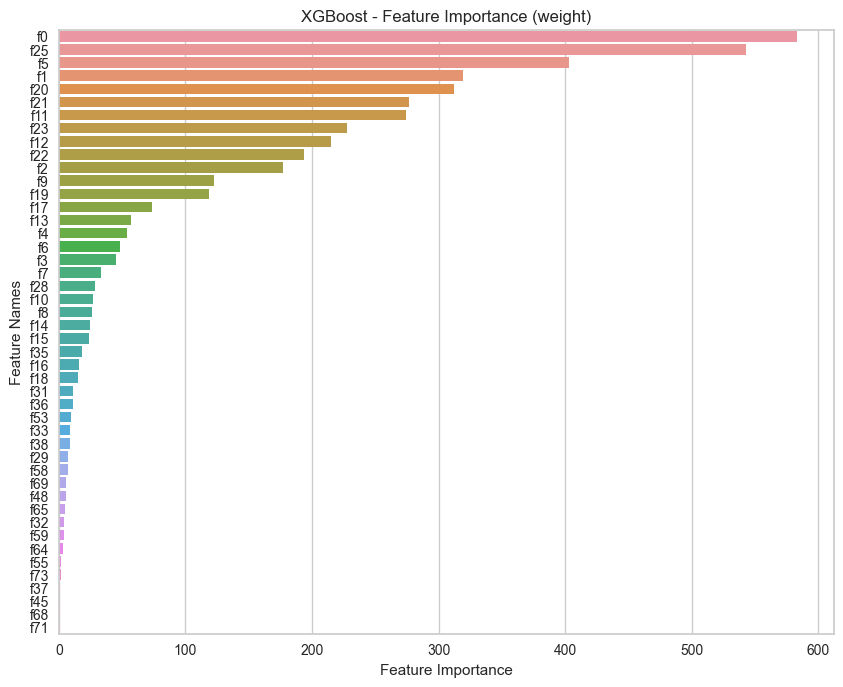

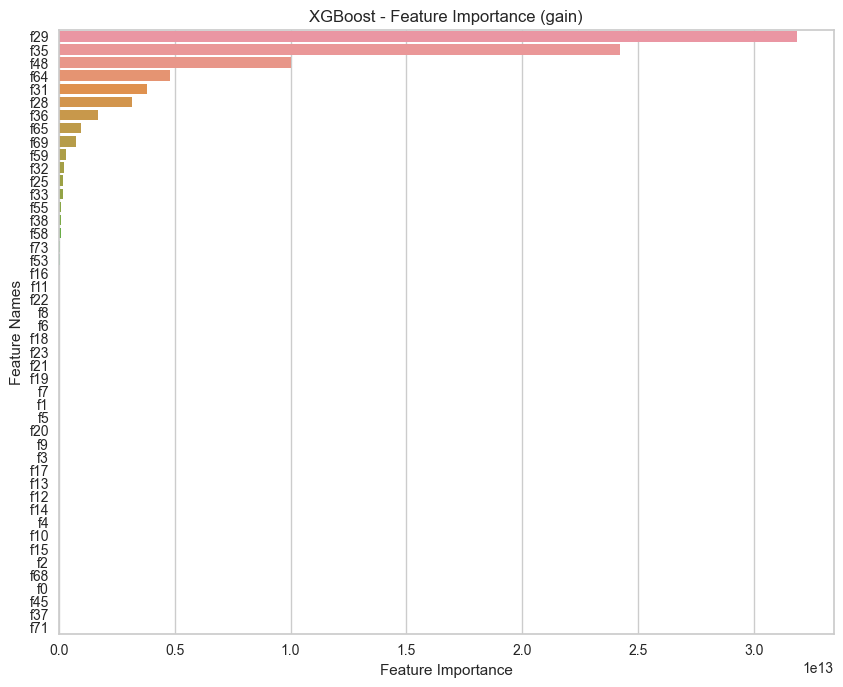

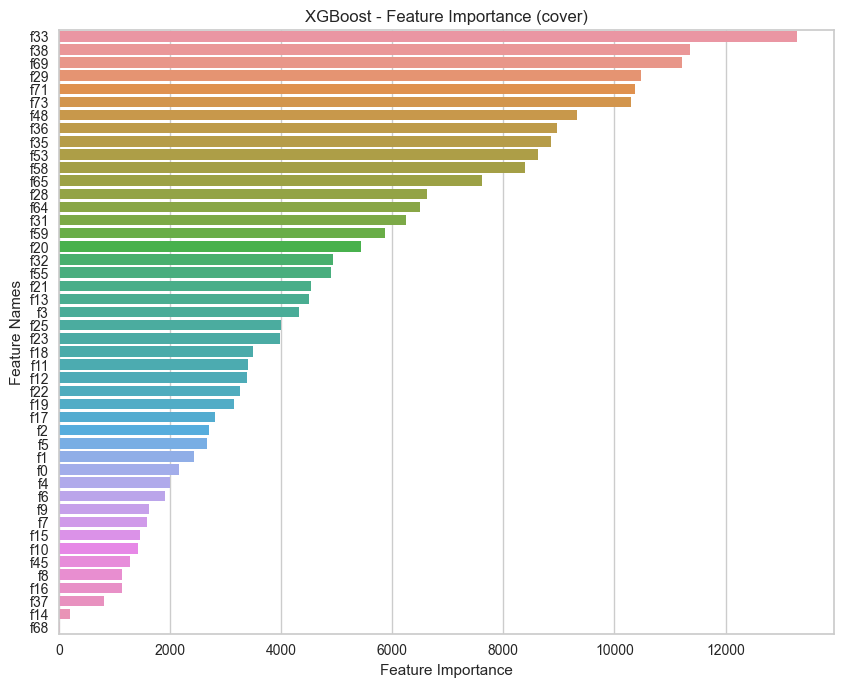

ValueError: All arrays must be of the same length

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

# Original feature names

# Initialize the Standard Scaler
scaler = MinMaxScaler()

# Replace with your actual data
# X_train and y_train should be your real training data
# X_train = your_data_here
# y_train = your_target_here
feature_names = ['latitude', 'longitude', 'neighborhood', 'property_type', 'property_class', 
                 'surface', 'bedrooms', 'bathrooms', 'lift', 'total_building_floors', 'garage_box', 
                 'condominium_expenses', 'year_of_construction', 'state', 'heating_type', 'common_garden', 
                 'city', 'energyClass', 'basement', 'mean_floor', 'nearest_hospital', 'nearest_transportation', 
                 'nearest_supermarket', 'distance_to_city_center']

# Function to generate PCA feature names
def generate_pca_feature_names(n_features):
    return [f'PCA_Feature_{i+1}' for i in range(n_features)]

# Choose the number of PCA features dynamically
n_features = 6  # Or you could use: int(input("Enter the number of PCA features you want: "))
pca_feature_names = generate_pca_feature_names(n_features)
feature_names.extend(pca_feature_names)
# Scale the features between 0 and 1
X_train = scaler.fit_transform(X_train)

# Function to plot feature importance
def plot_feature_importance(importance, names, model_type, importance_type):
    data = {'feature_names': names, 'feature_importance': importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'{model_type} - Feature Importance ({importance_type})')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

# Function to get and plot XGBoost feature importance
def xgb_importance(model, importance_type, feature_names):
    importance = model.get_booster().get_score(importance_type=importance_type)
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features, values = zip(*sorted_importance)
    plot_feature_importance(values, features, 'XGBoost', importance_type)

# Function to get and plot LightGBM feature importance
def lgbm_importance(model, importance_type, feature_names):
    importance = model.feature_importances_
    plot_feature_importance(importance, feature_names, 'LightGBM', importance_type)

# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Train LightGBM model
lgbm_model_gain = LGBMRegressor(importance_type='gain')
lgbm_model_gain.fit(X_train, y_train)
lgbm_model_split = LGBMRegressor(importance_type='split')
lgbm_model_split.fit(X_train, y_train)

# Plot feature importance
for importance_type in ['weight', 'gain', 'cover']:
    xgb_importance(xgb_model, importance_type, feature_names)

lgbm_importance(lgbm_model_gain, 'gain', feature_names)
lgbm_importance(lgbm_model_split, 'split', feature_names)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 30
[LightGBM] [Info] Start training from score 268770.931835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 30
[LightGBM] [Info] Start training from score 268770.931835


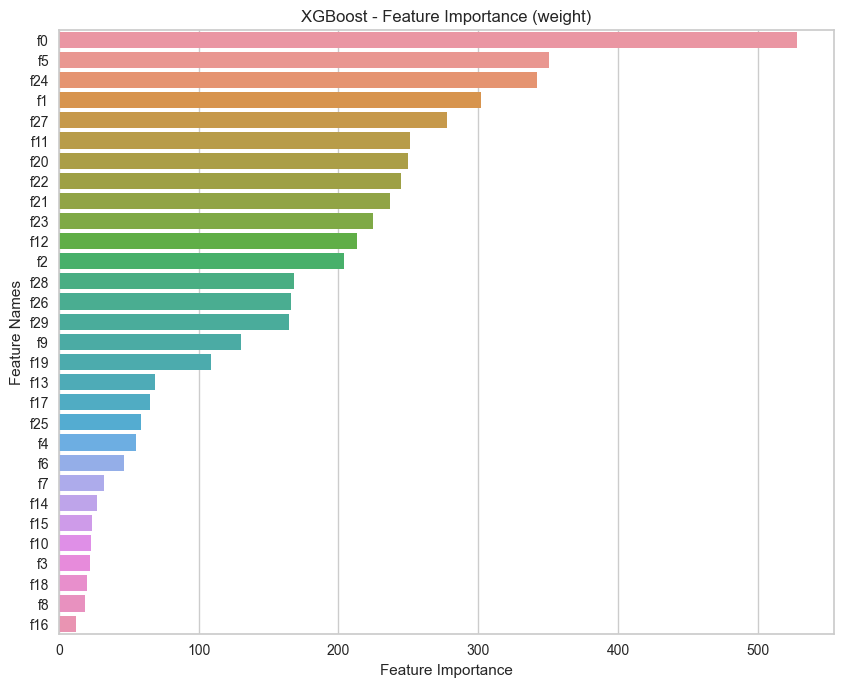

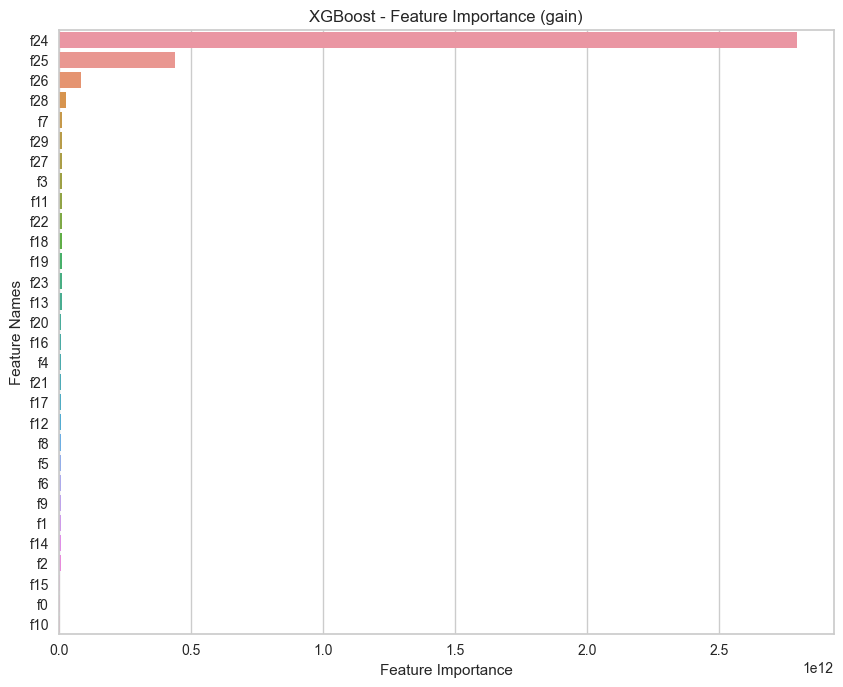

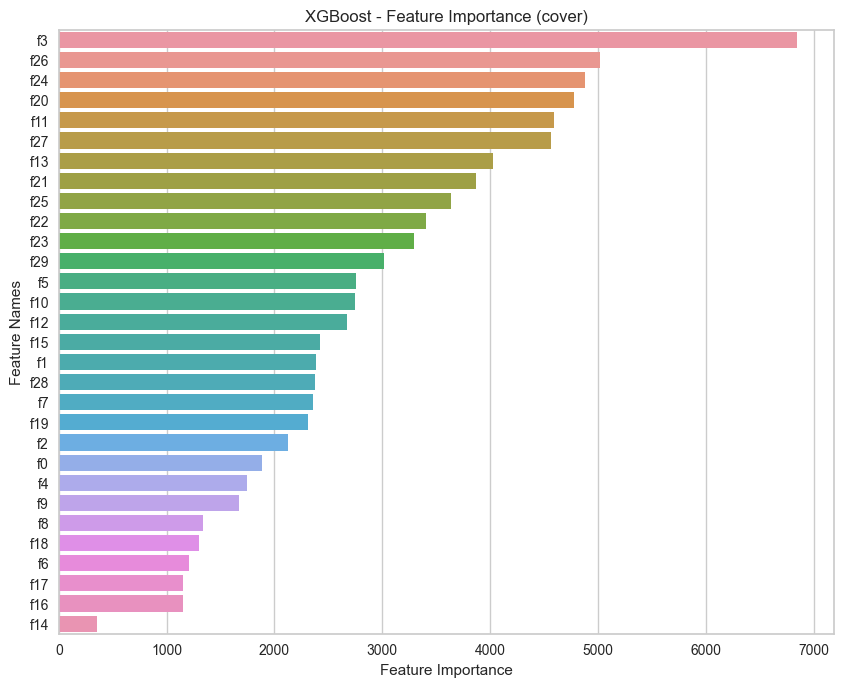

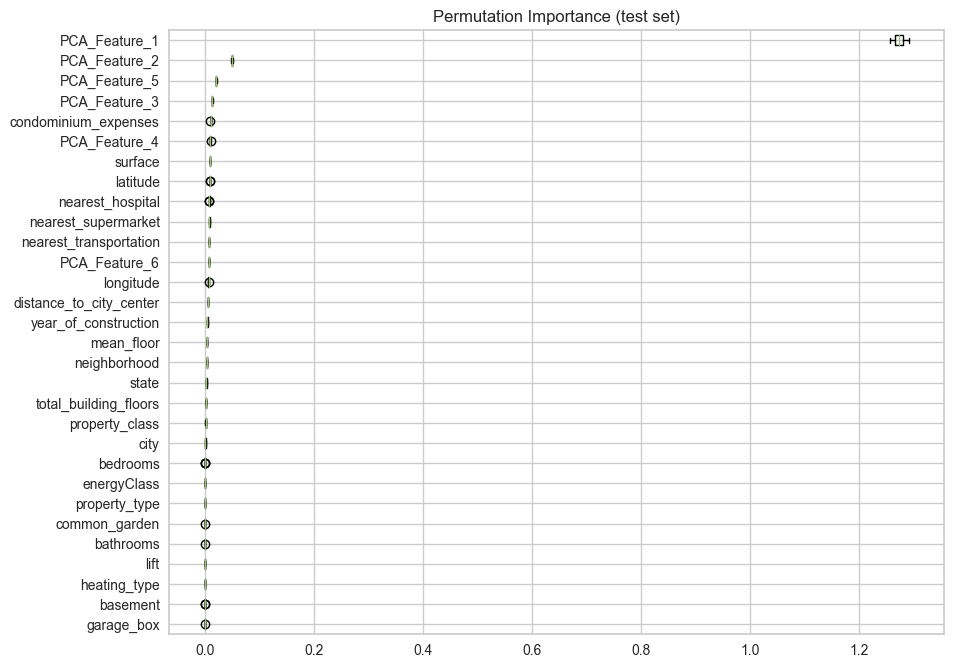

In [35]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

# Initialize the Standard Scaler
scaler = MinMaxScaler()

# Your actual data should replace these
# X_train = your_data_here
# y_train = your_target_here

# Original feature names
feature_names = ['latitude', 'longitude', 'neighborhood', 'property_type', 'property_class', 
                 'surface', 'bedrooms', 'bathrooms', 'lift', 'total_building_floors', 'garage_box', 
                 'condominium_expenses', 'year_of_construction', 'state', 'heating_type', 'common_garden', 
                 'city', 'energyClass', 'basement', 'mean_floor', 'nearest_hospital', 'nearest_transportation', 
                 'nearest_supermarket', 'distance_to_city_center']

# Generate PCA feature names
def generate_pca_feature_names(n_features):
    return [f'PCA_Feature_{i+1}' for i in range(n_features)]

n_features = 6
pca_feature_names = generate_pca_feature_names(n_features)
feature_names.extend(pca_feature_names)

# Scale the features
X_train = scaler.fit_transform(X_train)

# Function to plot feature importance
def plot_feature_importance(importance, names, model_type, importance_type):
    data = {'feature_names': names, 'feature_importance': importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'{model_type} - Feature Importance ({importance_type})')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Train LightGBM model
lgbm_model_gain = LGBMRegressor(importance_type='gain')
lgbm_model_gain.fit(X_train, y_train)
lgbm_model_split = LGBMRegressor(importance_type='split')
lgbm_model_split.fit(X_train, y_train)

# Plot native feature importance
for importance_type in ['weight', 'gain', 'cover']:
    xgb_importance(xgb_model, importance_type, feature_names)

# Permutation Importance
result = permutation_importance(xgb_model, X_train, y_train, n_repeats=30, random_state=0)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()


In [ ]:


# Initialize lists to store test set evaluation metrics for each model
test_mae_list = {}
test_mse_list = {}
test_rmse_list = {}
test_r2_list = {}
test_mape_list = {}

# Define the models and their respective parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [5, 10, 15, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [5, 9, 12, 15]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 150], 'max_depth': [8, 12, 16]}
    },
    'SVM': {
        'model': SVR(),
        'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {'n_estimators': [1000], 'learning_rate': [0.05, 0.1]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0, n_estimators=2000),
        'params': {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.05]}
    },
    'XGBoost': {
        'model': XGBRegressor(n_estimators=2000, learning_rate=0.05, random_state=42),
        'params': {'max_depth': [5, 7, 9], 'learning_rate': [0.01, 0.05, 0.1]}
    }
}

# Define the K-fold cross-validator
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# For each model
for name, model_info in models.items():
    test_mae_list[name] = []
    test_mse_list[name] = []
    test_rmse_list[name] = []
    test_r2_list[name] = []
    test_mape_list[name] = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Grid Search for hyperparameter tuning
        grid = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
        grid_result = grid.fit(X_train_fold, y_train_fold)
        best_model = grid_result.best_estimator_

        # Make predictions on the test set
        y_pred_test = best_model.predict(X_test)

        # Evaluate the model on the test set
        test_mae = mean_absolute_error((y_test), (y_pred_test))
        test_mse = mean_squared_error((y_test), (y_pred_test))
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score((y_test), (y_pred_test))
        test_mape = mean_absolute_percentage_error((y_test), (y_pred_test))

        # Store the test set metrics in the lists
        test_mae_list[name].append(test_mae)
        test_mse_list[name].append(test_mse)
        test_rmse_list[name].append(test_rmse)
        test_r2_list[name].append(test_r2)
        test_mape_list[name].append(test_mape)

    # Calculate the average and best metrics for the test set
    avg_test_mae = np.mean(test_mae_list[name])
    avg_test_mse = np.mean(test_mse_list[name])
    avg_test_rmse = np.mean(test_rmse_list[name])
    avg_test_r2 = np.mean(test_r2_list[name])
    avg_test_mape = np.mean(test_mape_list[name])

    best_test_mae = np.min(test_mae_list[name])
    best_test_mse = np.min(test_mse_list[name])
    best_test_rmse = np.min(test_rmse_list[name])
    best_test_r2 = np.max(test_r2_list[name])
    best_test_mape = np.min(test_mape_list[name])

    print(f"Test Set Evaluation for {name}")
    print(f"Average Test MAE: {avg_test_mae}, Best Test MAE: {best_test_mae}")
    print(f"Average Test MSE: {avg_test_mse}, Best Test MSE: {best_test_mse}")
    print(f"Average Test RMSE: {avg_test_rmse}, Best Test RMSE: {best_test_rmse}")
    print(f"Average Test R2: {avg_test_r2}, Best Test R2: {best_test_r2}")
    print(f"Average Test MAPE: {avg_test_mape}, Best Test MAPE: {best_test_mape}")
    print("\n")
